In [1]:
#This analysis explores London housing prices to identify affordable areas. 
#Using the kaggle london housing, I analyze pricing patterns, value for money, and affordability across different neighborhoods.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ds = pd.read_csv('London_housing.csv') #upload the dataset
print(ds.head()) #shows first 5 rows
print(ds.info()) #type of information

   Unnamed: 0  Property Name    Price        House Type  Area in sq ft  \
0           0    Queens Road  1675000             House           2716   
1           1  Seward Street   650000  Flat / Apartment            814   
2           2    Hotham Road   735000  Flat / Apartment            761   
3           3   Festing Road  1765000             House           1986   
4           4   Spencer Walk   675000  Flat / Apartment            700   

   No. of Bedrooms  No. of Bathrooms  No. of Receptions     Location  \
0                5                 5                  5    Wimbledon   
1                2                 2                  2  Clerkenwell   
2                2                 2                  2       Putney   
3                4                 4                  4       Putney   
4                2                 2                  2       Putney   

  City/County Postal Code  
0      London    SW19 8NY  
1      London    EC1V 3PA  
2      London    SW15 1QL  
3      Lon

In [4]:
def clean_with_metrics(df):
    """Data cleaning with impact reporting"""
    metrics = {}
    
    metrics['initial_rows'] = len(df)
    metrics['initial_missing'] = df.isnull().sum().sum()
    
    missing_before = df['Location'].isna().sum()
    df['Postal_District'] = df['Postal Code'].str.split(' ').str[0]
    
    postal_map = {...}  # Your existing mapping
    df['Location'] = df['Location'].fillna(df['Postal_District'].map(postal_map))
    
    missing_after = df['Location'].isna().sum()
    metrics['locations_recovered'] = missing_before - missing_after
    metrics['recovery_rate'] = (missing_before - missing_after) / missing_before * 100
    
    print(f"✓ Recovered {metrics['locations_recovered']} locations ({metrics['recovery_rate']:.1f}%)")
    
    return df, metrics

In [5]:
#correct apartments that are studios
ds.loc[(ds['No. of Bedrooms'] == 0) & (ds['Area in sq ft'] < 500), 'House Type'] = 'Studio'

In [6]:
location_prices = ds.groupby('Location')['Price'].agg(['mean', 'count']).reset_index()
location_prices = location_prices[location_prices['count'] >= 5]
location_prices = location_prices.sort_values('mean', ascending=False)

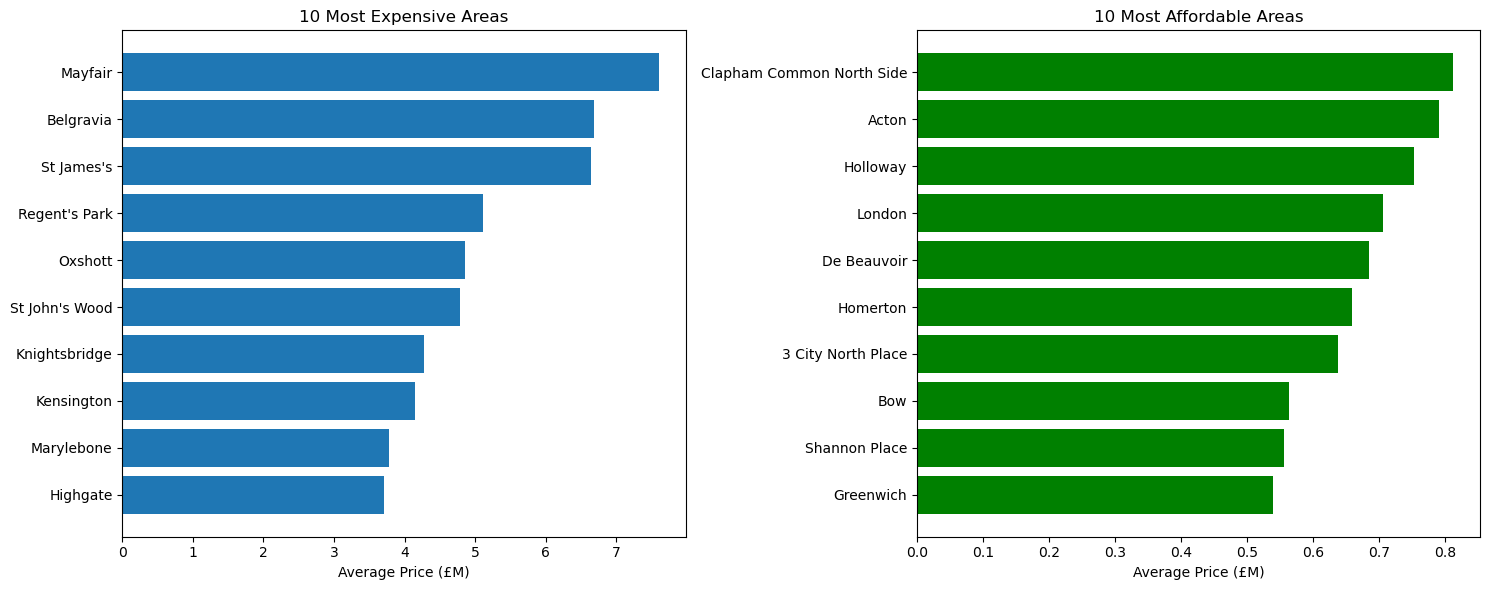

In [7]:
#Bar plots
top_10 = location_prices.head(10)
bottom_10 = location_prices.tail(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Most expensive
ax1.barh(top_10['Location'], top_10['mean']/1000000)
ax1.set_xlabel('Average Price (£M)')
ax1.set_title('10 Most Expensive Areas')
ax1.invert_yaxis()

# Most affordable
ax2.barh(bottom_10['Location'], bottom_10['mean']/1000000, color='green')
ax2.set_xlabel('Average Price (£M)')
ax2.set_title('10 Most Affordable Areas')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('expensive_vs_affordable.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Calculate affordability ratio
london_median_income = 40000  # Annual
ds['Price_to_Income_Ratio'] = ds['Price'] / london_median_income

print("\nHow many years of income to buy:")
print(ds.groupby('Location')['Price_to_Income_Ratio'].mean().sort_values(ascending=False).head(10))


How many years of income to buy:
Location
Hampstead Heath          598.75
30 Montpelier Walk       525.00
25 Cork Street           343.75
Regents Park             312.50
Prince Consort Road      273.75
Cheyne Terrace           248.75
100 Knightsbridge        248.75
10 Draycott Avenue       223.75
10 Whitehall Place       223.75
44 The Bishops Avenue    221.25
Name: Price_to_Income_Ratio, dtype: float64


In [9]:
ds['Price_per_sq_feet'] = ds['Price'] / ds['Area in sq ft']

In [10]:
#Affordable properties (under £600k)
affordable = ds[ds['Price'] <= 600000]
print(f"Found {len(affordable)} properties under £600k ({len(affordable)/len(ds)*100:.1f}%)")

# Best value areas
affordable_areas = affordable.groupby('Location').agg({
    'Price': 'mean',
    'Price_per_sq_feet': 'mean',
    'Area in sq ft': 'mean'
}).sort_values('Price_per_sq_feet')

print("\nBest Value Areas (under £600k):")
print(affordable_areas.head(10))

Found 531 properties under £600k (15.3%)

Best Value Areas (under £600k):
                      Price  Price_per_sq_feet  Area in sq ft
Location                                                     
Barwell Lane       375000.0         390.218522          961.0
Buckhurst Hill     405000.0         407.706228          996.0
Walton-on-Thames   375000.0         426.136364          880.0
Watford            475000.0         486.182190          977.0
Bushey             600000.0         495.687390         1210.5
Finsbury Park      399950.0         496.215881          806.0
20 Love Lane       400000.0         516.795866          774.0
10 Frobisher Yard  440000.0         519.480519          847.0
Lisson Grove       350000.0         522.388060          670.0
Hanger Lane        400000.0         523.560209          764.0


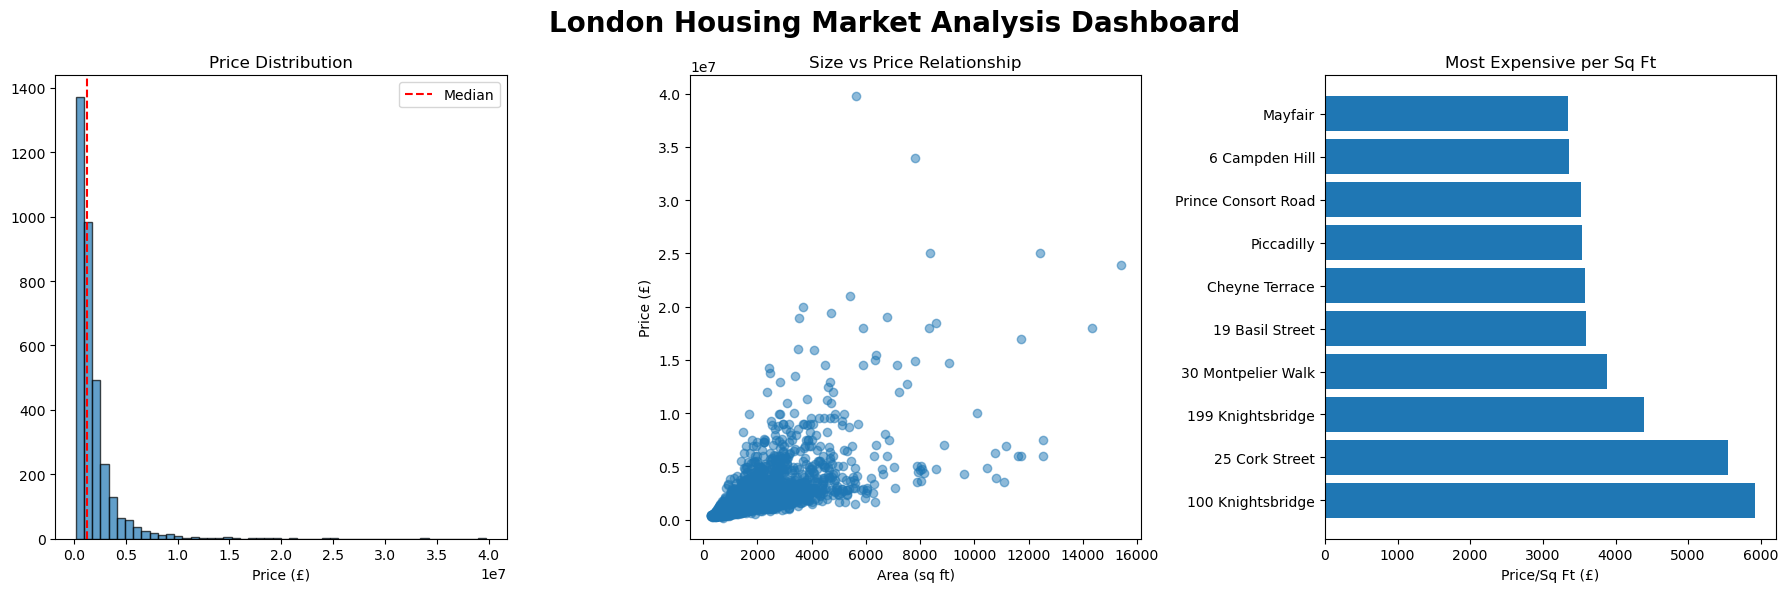

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('London Housing Market Analysis Dashboard',
             fontsize=20, fontweight='bold')

# 1. Price distribution
axes[0].hist(ds['Price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(ds['Price'].median(), color='red', linestyle='--', label='Median')
axes[0].set_xlabel('Price (£)')
axes[0].set_title('Price Distribution')
axes[0].legend()

# 2. Size vs Price scatter
axes[1].scatter(ds['Area in sq ft'], ds['Price'], alpha=0.5)
axes[1].set_xlabel('Area (sq ft)')
axes[1].set_ylabel('Price (£)')
axes[1].set_title('Size vs Price Relationship')

# 3. Price/sqft by location
top_psqft = (
    ds.groupby('Location')['Price_per_sq_feet']
      .mean()
      .nlargest(10)
)
axes[2].barh(top_psqft.index, top_psqft.values)
axes[2].set_xlabel('Price/Sq Ft (£)')
axes[2].set_title('Most Expensive per Sq Ft')

plt.tight_layout()
plt.savefig('analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
#Calculate average by House Type
average_per_type = (
    ds.groupby('House Type', as_index=False)['Price']
      .mean()
      .rename(columns={'Price': 'Average Price'})
      .sort_values(by='Average Price', ascending=True)
)

average_per_type['Average Price'] = average_per_type['Average Price'].round(0)
print(average_per_type)

         House Type  Average Price
7            Studio       377091.0
0          Bungalow       904444.0
1            Duplex       934286.0
2  Flat / Apartment      1251813.0
4              Mews      1400000.0
5   New development      2190843.0
3             House      2388378.0
6         Penthouse      3112847.0


/var/folders/x0/8yff0_gj7cv0r8khfrp9gzn40000gn/T/ipykernel_26921/3123502752.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


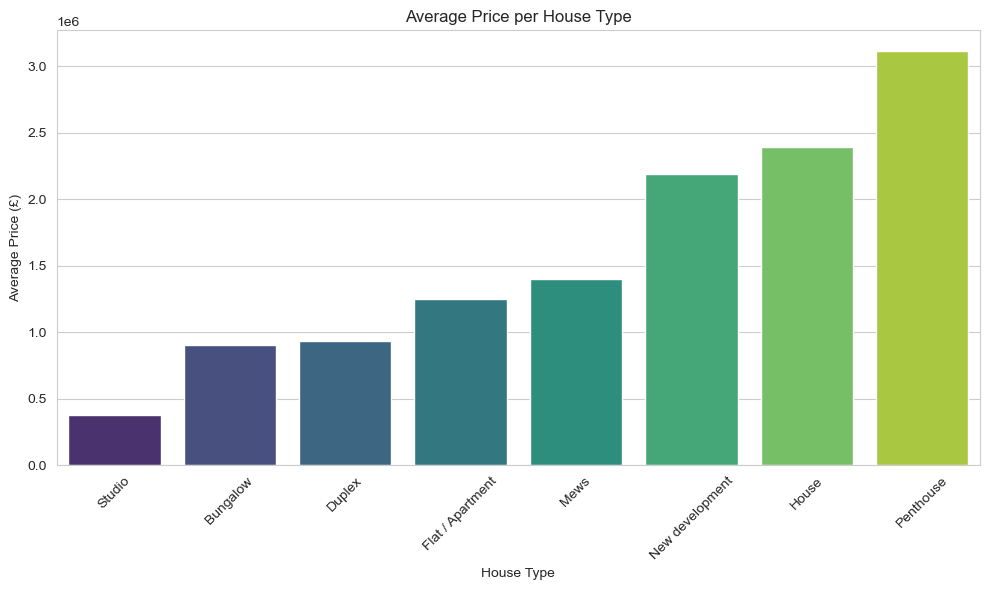

In [13]:
#Calculate histogram of the average
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=average_per_type,
    x='House Type',
    y='Average Price',
    palette='viridis'
)
plt.xticks(rotation=45)
plt.title('Average Price per House Type')
plt.ylabel('Average Price (£)')
plt.xlabel('House Type')
plt.tight_layout()
plt.show()


In [ ]:
#Areas like Barwell Lane, Buckhurst Hill and Walton-on-Thames offer the best value under £600k. 
#Penthouse is the most expensive house type followed by a house.
#Bungalow and duplex have very similar value.
#Cheapest area is Greenwhich
#Limitations: This analysis doesn't account for transport links or future development plans.